In [2]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools 
from statsmodels.tsa.stattools import adfuller

import requests
from io import BytesIO
from pandas_datareader.data import DataReader
import pandas_datareader.data as web

from datetime import datetime


import xlsxwriter

import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.axes

import os
import sys
import scipy.stats as scs


C:\Users\Dell\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
USA = pd.read_excel('USA.xlsx')

In [4]:
USA.set_index(USA['Date'], inplace=True)
USA.set_index('Date', inplace=True)

In [5]:
dateparse = lambda USA: pd.to_datetime(USA, format='%m%d%Y')

In [103]:
print USA.head()


                USA
Date               
1/29/1999  0.040428
2/26/1999 -0.029831
3/31/1999  0.038922
4/30/1999  0.033940
5/28/1999 -0.024889


In [16]:
USA['rol_mean'] = USA['USA'].rolling(window=60, center=False).mean() 
USA['rol_std'] = USA["USA"].rolling(window=60,center=False).std()

In [46]:
rol_mean = USA['USA'].rolling(window=60, center=False).mean() 
rol_std = USA["USA"].rolling(window=60,center=False).std()

In [71]:
def tsplot(y, lags=None, figsize=(18, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

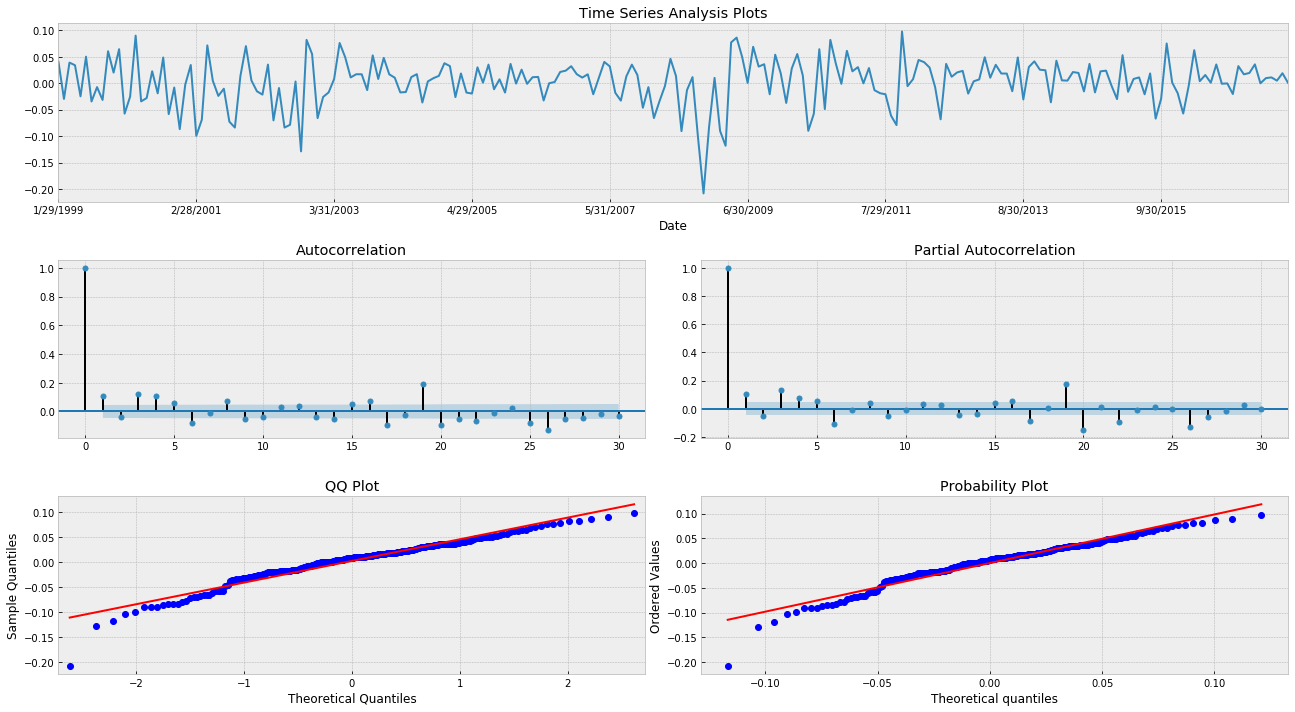

In [72]:
_ = tsplot(USA["USA"], lags=30)

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [53]:
test_stationarity(USA["USA"])

Results of Dickey-Fuller Test:
Test Statistic                -7.399534e+00
p-value                        7.619544e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (5%)           -2.874709e+00
Critical Value (1%)           -3.460291e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


In [55]:
mod1 = sm.tsa.MarkovAutoregression(USA["USA"], k_regimes=2, order=3, switching_ar=False)
res1 = mod1.fit()
print (res1.summary())

                         Markov Switching Model Results                         
Dep. Variable:                      USA   No. Observations:                  221
Model:             MarkovAutoregression   Log Likelihood                 384.557
Date:                  Sun, 26 Nov 2017   AIC                           -753.114
Time:                          01:18:43   BIC                           -725.929
Sample:                      04-30-1999   HQIC                          -742.138
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0094      0.016     -0.591      0.555      -0.041       0.022
                             Regime 

In [56]:
mdl = smt.AR(USA["USA"]).fit(maxlag=3, ic='aic', trend='nc')
%time est_order = smt.AR(USA["USA"]).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 3
print ('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
print ('\ntrue alpha = {} | true order = {}'
  .format(res1.params['ar.L1'], true_order))
print ('\ntrue alpha = {} | true order = {}'
  .format(res1.params['ar.L2'], true_order))
print ('\ntrue alpha = {} | true order = {}'
  .format(res1.params['ar.L3'], true_order))

Wall time: 15.5 s

alpha estimate: 0.12674 | best lag order = 1

true alpha = 0.249827071494 | true order = 3

true alpha = -0.173904609865 | true order = 3

true alpha = 0.202962390697 | true order = 3


In [18]:
mod2 = sm.tsa.MarkovAutoregression(USA["USA"], k_regimes=2, order=2, switching_ar=False)
res2 = mod2.fit()
print (res2.summary())

                         Markov Switching Model Results                         
Dep. Variable:                      USA   No. Observations:                  222
Model:             MarkovAutoregression   Log Likelihood                 383.333
Date:                  Sun, 26 Nov 2017   AIC                           -752.666
Time:                          23:51:42   BIC                           -728.848
Sample:                      03-31-1999   HQIC                          -743.050
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.047      0.045      0.964      -0.089       0.093
                             Regime 

Date
3/31/1999    0.499808
4/30/1999    0.499808
5/28/1999    0.499810
6/30/1999    0.499807
7/30/1999    0.499811
Name: 0, dtype: float64


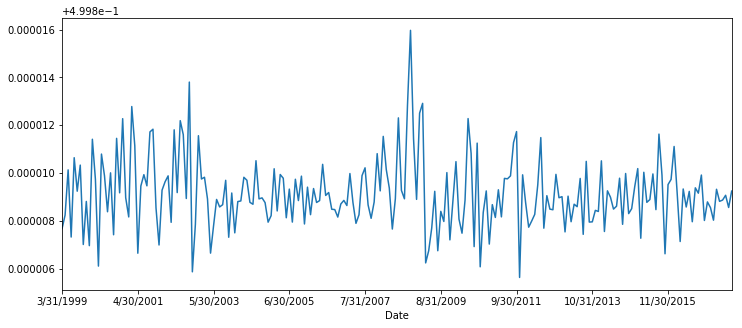

In [84]:
fmp=res2.filtered_marginal_probabilities[0]
fig = plt.figure(figsize=(12, 5))
fmp.plot()
print fmp.head()

In [85]:
print(res2.expected_durations)

[ 1.99926154  2.0007884 ]


In [47]:
rol_mean= rol_mean.dropna()

In [48]:
test_stationarity(rol_mean)

Results of Dickey-Fuller Test:
Test Statistic                  -2.144641
p-value                          0.226947
#Lags Used                       4.000000
Number of Observations Used    160.000000
Critical Value (5%)             -2.879780
Critical Value (1%)             -3.471896
Critical Value (10%)            -2.576495
dtype: float64


In [49]:
data = rol_mean.diff()
data = data.dropna()

In [50]:
writer1 = pd.ExcelWriter('RM.xlsx', engine='xlsxwriter')
   
data.to_excel(writer1, 'Sheet1')

writer1.save()



In [6]:
RM = pd.read_excel('RM.xlsx')
RM.set_index(RM['Date'], inplace=True)
RM.set_index('Date', inplace=True)
dateparse = lambda RM: pd.to_datetime(RM, format='%m%d%Y')

In [52]:
print RM.head()

                USA
Date               
1/30/2004 -0.000395
2/27/2004  0.000670
3/31/2004 -0.000940
4/30/2004 -0.000845
5/28/2004  0.000607


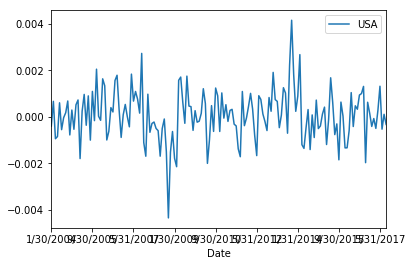

In [53]:
RM.plot()

In [54]:
test_stationarity(RM["USA"])

Results of Dickey-Fuller Test:
Test Statistic                  -4.431415
p-value                          0.000261
#Lags Used                       3.000000
Number of Observations Used    160.000000
Critical Value (5%)             -2.879780
Critical Value (1%)             -3.471896
Critical Value (10%)            -2.576495
dtype: float64


In [30]:
# difference of 3 year rolling returns

In [7]:
# better model
mod3 = sm.tsa.MarkovAutoregression(RM["USA"], k_regimes=2, order=1, switching_ar=False)
res3 = mod3.fit()
print (res3.summary())

                         Markov Switching Model Results                         
Dep. Variable:                      USA   No. Observations:                  163
Model:             MarkovAutoregression   Log Likelihood                 884.278
Date:                  Sun, 26 Nov 2017   AIC                          -1756.557
Time:                          23:43:51   BIC                          -1737.994
Sample:                      02-27-2004   HQIC                         -1749.020
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         7.9e-05      0.001      0.060      0.952      -0.003       0.003
                             Regime 

In [56]:
print(res3.expected_durations)

[ 1.99856461  2.00109787]


In [65]:
mod4 = sm.tsa.MarkovAutoregression(RM["USA"], k_regimes=2, order=1)
res4 = mod4.fit()
print (res4.summary())

                         Markov Switching Model Results                         
Dep. Variable:                      USA   No. Observations:                  163
Model:             MarkovAutoregression   Log Likelihood                 886.369
Date:                  Sun, 26 Nov 2017   AIC                          -1758.738
Time:                          16:33:45   BIC                          -1737.081
Sample:                      02-27-2004   HQIC                         -1749.946
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.625      0.532      -0.000       0.000
ar.L1         -0.3043      0.187    

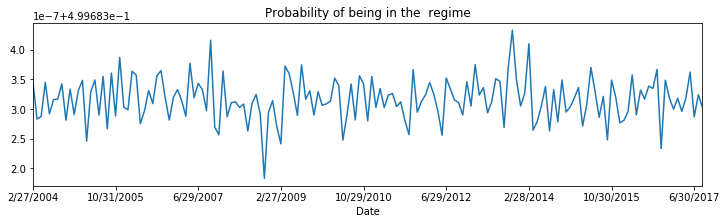

In [57]:
res3.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the  regime', figsize=(12,3))

In [125]:
#This model demonstrates estimation with regime heteroskedasticity (switching of variances) and no mean effect. 

mod_kns = sm.tsa.MarkovRegression(RM["USA"], k_regimes=2, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
print(res_kns.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    USA   No. Observations:                  164
Model:               MarkovRegression   Log Likelihood                 893.007
Date:                Sun, 26 Nov 2017   AIC                          -1778.014
Time:                        17:33:48   BIC                          -1765.615
Sample:                    01-30-2004   HQIC                         -1772.980
                         - 08-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.121e-07        nan        nan        nan         nan         nan
                             Regime 1 parameters    

In [68]:
#Filardo (1994) Time-Varying Transition Probabilities

In [150]:
f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m
start = pd.to_datetime('1999-01-29')
end = pd.datetime.today()
data = (web.DataReader([f1, f2, f3], 'fred', start, end))

In [151]:
writer = pd.ExcelWriter('TED.xlsx', engine='xlsxwriter')
   
data.to_excel(writer, 'Sheet1')

writer.save()

In [175]:
FED = pd.read_excel('TED.xlsx')

In [176]:
FED.set_index(FED['DATE'], inplace=True)
FED.set_index('DATE', inplace=True)

In [177]:
print FED.head()

            T10Y3M
DATE              
1999-01-29    0.18
1999-02-26    0.63
1999-03-31    0.76
1999-04-30    0.81
1999-05-31    0.81


In [24]:
predict = res2.predict()


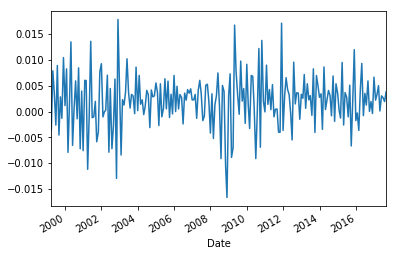

In [25]:
predict.plot()